## Spike sorting demo for BRW files
----

https://gist.github.com/mhhennig/97453faec66ea78f96e61a193f699e6c


**load libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib
import sys, os

import spikeinterface.full as si
import spikeinterface.preprocessing as st

%matplotlib inline

Set the file path to the raw data, contained within a ```.brw``` file format.

In [2]:
raw_file = pathlib.Path('data', 's2_bs.brw')

# check the file path
if not raw_file.exists():
    print(f'File {raw_file} does not exist')
    sys.exit(1)

Initalized the object.

Files are stored as discrete 64-bit integers.

In [3]:
RX = si.BiocamRecordingExtractor(raw_file)
RX

BiocamRecordingExtractor: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                          150.00s (2.50 minutes) - uint16 dtype - 15.76 GiB
  file_path: c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\data\s2_bs.brw

Select channels within the centre.

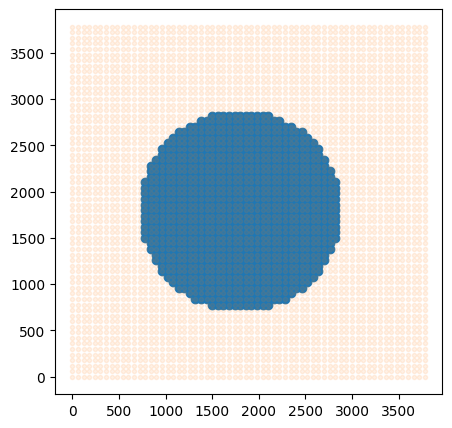

In [4]:
channel_locations = RX.get_channel_locations()

# pick the 1000 channels within the center
center = np.array([1800, 1800])
distances = np.linalg.norm(channel_locations - center, axis=1)
indices = np.argsort(distances)
channel_ids = indices[:1000]

# plot the channel locations
plt.figure(figsize=(5, 5))
plt.plot(channel_locations[channel_ids, 0], channel_locations[channel_ids, 1], 'o')

# plot the remaining channels
plt.plot(channel_locations[:, 0], channel_locations[:, 1], '.', alpha=0.1)

Convert channel ids to strings.

In [5]:
# convert the channel ids to strings
channel_ids = [str(ch) for ch in channel_ids]

Plot the raw traces.

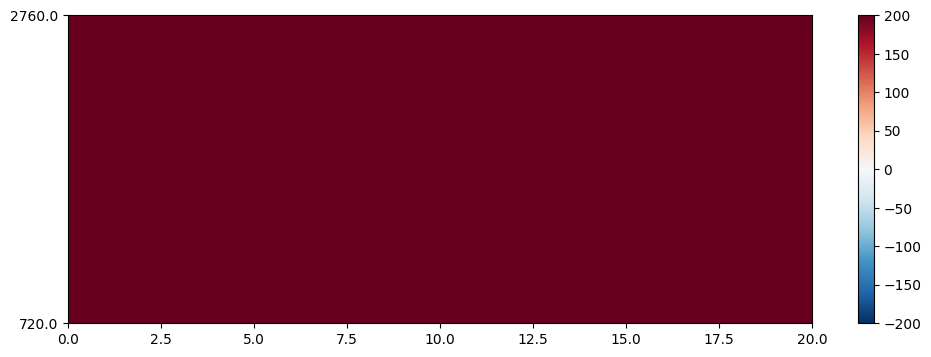

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(RX, time_range=[0,20], ax=ax, channel_ids=channel_ids, color='k')

## Pre-processing
---

Bandpass filter.

In [7]:
RX_filtered_bpass = si.bandpass_filter(RX, freq_min=300, freq_max=3000)
RX_filtered_bpass

BandpassFilterRecording: 4096 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                         150.00s (2.50 minutes) - int16 dtype - 15.76 GiB

Subselect for the active channels.

In [8]:
rec_clean = RX_filtered_bpass.select_channels(channel_ids)
rec_clean

ChannelSliceRecording: 1000 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                       150.00s (2.50 minutes) - int16 dtype - 3.85 GiB

Common median reference.

In [9]:
recording_cmr = st.common_reference(recording=rec_clean, operator="median")
recording_cmr

CommonReferenceRecording: 1000 channels - 13.8kHz - 1 segments - 2,066,017 samples 
                          150.00s (2.50 minutes) - int16 dtype - 3.85 GiB

Bandpass filter and re-plot the data.

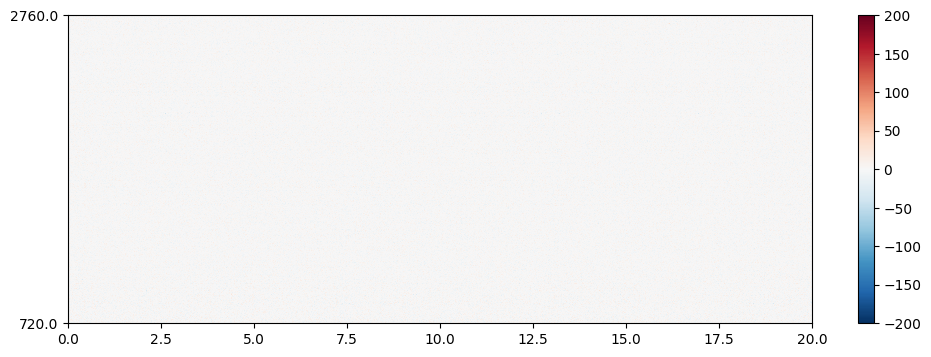

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
si.plot_traces(recording_cmr, time_range=[0, 20], ax=ax)

## Spike-sorting
-----

First, check the available sorters.

In [11]:
import spikeinterface.sorters as ss
ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'simple',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

Set the default sorting parameters.

In [12]:
sorter_params = si.get_default_sorter_params('kilosort2')
sorter_params  # check the car here --> possible to rmeove this?

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'whiteningRange': 32,
 'momentum': [20.0, 400.0],
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'freq_min': 150,
 'sigmaMask': 30,
 'lam': 10.0,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'AUCsplit': 0.9,
 'wave_length': 61,
 'keep_good_only': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'save_rez_to_mat': False,
 'delete_tmp_files': ('matlab_files',),
 'delete_recording_dat': False,
 'n_jobs': 1,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_process': 1}

In [13]:
# loading kwargs
n_cpus = os.cpu_count()
n_jobs = n_cpus - 4
sorter_params['n_jobs'] = n_jobs

# create an object, passing the recording extractor
hs = si.run_sorter(sorter_name='kilosort2', recording=recording_cmr, output_folder='data/hs_output_allchans', docker_image=True, verbose=True, **sorter_params)

print(f'KS2 found: {hs.get_num_units()} units')

C:\Users\michael.zabolocki\AppData\Local\Temp\ipykernel_26500\1760266550.py:7: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  hs = si.run_sorter(sorter_name='kilosort2', recording=recording_cmr, output_folder='data/hs_output_allchans', docker_image=True, verbose=True, **sorter_params)


installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing spikeinterface with github in container
Installing neo with pypi in container
Running kilosort2 sorter inside spikeinterface/kilosort2-compiled-base
Stopping container
KS2 found: 41 units


In [14]:
hs = hs.remove_empty_units()
print(f'KS2 found {len(hs.get_unit_ids())} non-empty units')

KS2 found 41 non-empty units


Extract waveforms.

In [15]:
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)
we = si.extract_waveforms(recording_cmr, hs, folder="data/waveforms_sparse_allchans", sparse=False, overwrite=None, **job_kwargs)

####
# extract_waveforms() and WaveformExtractor() have been replaced by the `SortingAnalyzer` since version 0.101.0.
# You should use `spikeinterface.create_sorting_analyzer()` instead.
# `spikeinterface.extract_waveforms()` is now mocking the old behavior for backwards compatibility only,
# and will be removed with version 0.103.0
####


c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\sortinganalyzer.py:246: UserWarning: Sorting and Recording have a small difference in sampling frequency. This could be due to rounding of floats. Using the sampling frequency from the Recording.
  warnings.warn(


compute_waveforms:   0%|          | 0/151 [00:00<?, ?it/s]

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(


In [16]:
for unit in hs.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = hs.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 8 - num spikes: 8
Unit 1 - num waveforms: 15 - num spikes: 15
Unit 2 - num waveforms: 117 - num spikes: 117
Unit 3 - num waveforms: 99 - num spikes: 99
Unit 4 - num waveforms: 500 - num spikes: 572
Unit 5 - num waveforms: 99 - num spikes: 99
Unit 6 - num waveforms: 226 - num spikes: 226
Unit 7 - num waveforms: 233 - num spikes: 233
Unit 8 - num waveforms: 43 - num spikes: 43
Unit 9 - num waveforms: 433 - num spikes: 433
Unit 10 - num waveforms: 9 - num spikes: 9
Unit 11 - num waveforms: 318 - num spikes: 318
Unit 12 - num waveforms: 14 - num spikes: 14
Unit 13 - num waveforms: 24 - num spikes: 24
Unit 14 - num waveforms: 78 - num spikes: 78
Unit 15 - num waveforms: 22 - num spikes: 22
Unit 17 - num waveforms: 109 - num spikes: 109
Unit 18 - num waveforms: 21 - num spikes: 21
Unit 19 - num waveforms: 249 - num spikes: 249
Unit 20 - num waveforms: 500 - num spikes: 896
Unit 21 - num waveforms: 500 - num spikes: 2497
Unit 22 - num waveforms: 199 - num spikes: 199
U

Automatic unit removals.

In [17]:
import spikeinterface.qualitymetrics as sqm
qm = sqm.compute_quality_metrics(we, verbose=False, n_jobs=n_jobs)

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:745: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1483: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(


Set quality control metrics.

In [18]:
isi_viol_thresh = 0.01  # <= 1% ISI violations of total spikes
firing_rate_thresh = 0.5
snr_thresh = 5
presence_ratio_cutoff = 0.8

In [19]:
qc_query = f"isi_violations_count/num_spikes <= {isi_viol_thresh} & firing_rate > {firing_rate_thresh} & snr >= {snr_thresh} & presence_ratio >= {presence_ratio_cutoff}"

# query for units that pass quality metrics
keep_units = qm.query(qc_query)
keep_unit_ids = keep_units.index.values

print(f"Units that pass quality metrics: {keep_unit_ids}")

# select units that pass quality metrics
# in sorting extractor
sorting_postqc = hs.select_units(keep_unit_ids)

we_postqc = we.select_units(keep_unit_ids)
we_postqc

Units that pass quality metrics: [ 3  4  5  6 14 17 19 21 22 24 28 30 36 38 39 40 41]


SortingAnalyzer: 1000 channels - 17 units - 1 segments - memory - has recording
Loaded 5 extensions: random_spikes, waveforms, templates, noise_levels, quality_metrics

Isolate the template metrics.

In [20]:
metric_names = si.get_quality_metric_list()
qm_params = si.get_default_qm_params()
qm = si.compute_quality_metrics(we_postqc, metric_names=metric_names, verbose=True, qm_params=qm_params, **job_kwargs)
qm

Computing amplitude_cutoff
Computing amplitude_cv
Computing amplitude_median


c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:902: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:745: UserWarning: compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'
  warnings.warn("compute_amplitude_cv_metrics() need 'spike_amplitudes' or 'amplitude_scalings'")


Computing drift
Computing firing_range
Computing firing_rate
Computing isi_violation
Computing num_spikes
Computing presence_ratio
Computing rp_violation
Computing sd_ratio
Computing sliding_rp_violation
Computing snr
Computing synchrony


c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1041: UserWarning: The drift metrics require the `spike_locations` waveform extension. Use the `postprocessing.compute_spike_locations()` function. Drift metrics will be set to NaN
  warnings.warn(
c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1483: UserWarning: The `sd_ratio` metric require the `spike_amplitudes` waveform extension. Use the `postprocessing.compute_spike_amplitudes()` functions. SD ratio metric will be set to NaN
  warnings.warn(


,amplitude_cutoff,amplitude_cv,amplitude_median,drift_ptp,drift_std,drift_mad,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
3,NaN,NaN,-226.617828,NaN,NaN,NaN,2.88,0.660000,0.000000,0,99,1.0,0.000000,0,NaN,NaN,14.221054,0.000000,0.0,0.0
4,0.001239,NaN,-117.216118,NaN,NaN,NaN,11.64,3.813333,0.305638,2,572,1.0,0.687074,2,NaN,NaN,6.891042,0.008741,0.0,0.0
5,NaN,NaN,-160.195358,NaN,NaN,NaN,2.62,0.660000,0.000000,0,99,1.0,0.000000,0,NaN,NaN,9.340662,0.010101,0.0,0.0
6,NaN,NaN,-142.612946,NaN,NaN,NaN,9.30,1.506667,0.000000,0,226,1.0,0.000000,0,NaN,NaN,9.047918,0.000000,0.0,0.0
14,NaN,NaN,-185.592194,NaN,NaN,NaN,1.91,0.520000,0.000000,0,78,1.0,0.000000,0,NaN,NaN,10.803370,0.000000,0.0,0.0
17,NaN,NaN,-195.360199,NaN,NaN,NaN,2.91,0.726667,0.000000,0,109,1.0,0.000000,0,NaN,NaN,12.260451,0.000000,0.0,0.0
19,NaN,NaN,-89.865692,NaN,NaN,NaN,6.66,1.660000,0.000000,0,249,1.0,0.000000,0,NaN,NaN,7.344893,0.004016,0.0,0.0
21,0.001159,NaN,-117.216118,NaN,NaN,NaN,4.24,16.646665,0.008019,1,2497,1.0,0.000000,0,NaN,0.015,6.839777,0.004005,0.0,0.0
22,NaN,NaN,-132.844940,NaN,NaN,NaN,3.22,1.326667,1.262595,1,199,1.0,0.000000,0,NaN,NaN,7.047683,0.005025,0.0,0.0
24,NaN,NaN,-89.865692,NaN,NaN,NaN,1.33,0.506667,0.000000,0,76,1.0,0.000000,0,NaN,NaN,5.221378,0.000000,0.0,0.0


Check the rasterplot.

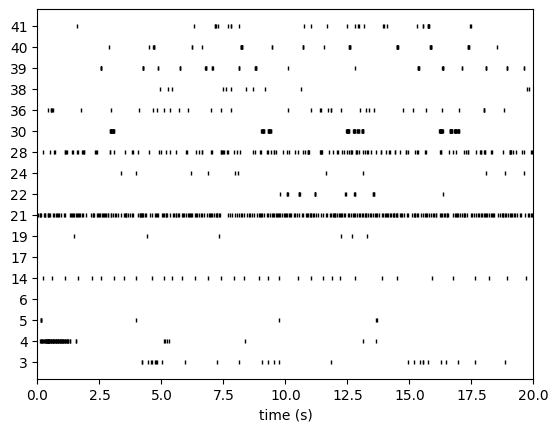

In [21]:
w_rs = si.plot_rasters(sorting_postqc, time_range=(0, 20), backend="matplotlib")

## Export to Phy
----

Use Phy2 for manual curations.

In [ ]:
si.export_to_phy(we_postqc, output_folder= 'data/phy_KS2_allchans', 
                 compute_amplitudes=True, compute_pc_features=True, copy_binary=True,
                 **job_kwargs)

c:\Users\michael.zabolocki\Documents\code\3brain_gradelab\.venv\lib\site-packages\spikeinterface\exporters\to_phy.py:89: UserWarning: Exporting to Phy with many channels and without sparsity might result in a heavy and less informative visualization. You can use use a sparse SortingAnalyzer or you can use the 'sparsity' argument to enforce sparsity (see compute_sparsity())
  warnings.warn(


write_binary_recording:   0%|          | 0/151 [00:00<?, ?it/s]

**perform a manual curation**

## Analyzer computation
-----

In [ ]:
from spikeinterface import create_sorting_analyzer, load_sorting_analyzer

analyzer = create_sorting_analyzer(sorting=hs,
                                   recording=recording_cmr,
                                   format="binary_folder",
                                   return_scaled=True, # this is the default to attempt to return scaled
                                   folder= "data/analyzer_folder"
                                   )

In [ ]:
analyzer.compute(
    "random_spikes",
    method="uniform",
    max_spikes_per_unit=500,
)
analyzer.compute("waveforms", ms_before=1.0, ms_after=2.0)
analyzer.compute("templates", operators=["average", "median", "std"])
print(analyzer)

In [ ]:
analyzer.compute("templates", operators=["average", "median", "std"])

ext_templates = analyzer.get_extension("templates")
av_templates = ext_templates.get_data(operator="average")
print(av_templates.shape)

In [ ]:
# core extensions
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels", "correlograms"])

# more extensions
analyzer.compute(["spike_amplitudes", "unit_locations", "spike_locations", "template_metrics", "quality_metrics", "template_similarity"])

In [ ]:
si.export_report(analyzer, output_folder= 'data/report_KS2')

In [ ]:
si.plot_unit_locations(analyzer, figsize=(8, 12))

In [ ]:
unit_ids = hs.unit_ids
si.plot_unit_templates(analyzer, unit_ids=unit_ids, ncols=5, figsize=(16, 8))

**TO DO**

- Benchmark multiple different sorting algorithms here